# Portfolio Selection

In [1]:
import pandas as pd
import utils
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from operator import itemgetter

## Clean data

In [2]:
# SP500
df_1 = pd.read_csv("sp500-info.csv", index_col="Date", parse_dates=True)

print(sum(df_1.isna().sum() != 0), "stock(s) don't have enough value.")

df_clean_1 = utils.clean_data(df_1, out_df_dir="sp500_clean.csv")

# SP400
df_2 = pd.read_csv("sp400-info.csv", index_col="Date", parse_dates=True)

print(sum(df_2.isna().sum() != 0), "stock(s) don't have enough value.")

df_clean_2 = utils.clean_data(df_2, out_df_dir="sp400_clean.csv")

df_clean = pd.concat([df_clean_1, df_clean_2], axis = 1)
df_clean.head()


2 stock(s) don't have enough value.
8 stock(s) don't have enough value.


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WU,WWD,WWE,X,XPO,XRX,Y,YELP,YETI,ZD
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-23,62.521873,10.25,76.780159,55.566658,58.500195,71.623451,132.339996,60.947273,139.870514,307.269989,...,17.245872,49.938290,37.082069,5.389979,25.826542,14.611341,452.839996,18.510000,15.580000,54.808697
2020-03-24,66.103294,13.92,84.487518,61.141407,61.212063,77.358749,143.669998,67.612480,152.680710,310.000000,...,17.766504,57.433014,38.379738,5.895289,26.885914,15.899240,486.739990,20.639999,18.650000,57.791306
2020-03-25,68.076515,15.39,88.390114,60.804588,61.593002,72.999146,146.889999,68.640869,147.784409,305.910004,...,17.887362,65.196098,33.798553,5.816025,31.135040,16.887844,515.830017,21.059999,21.330000,57.286957
2020-03-26,72.733368,15.66,94.992233,64.004311,66.962318,81.534279,149.169998,73.550034,166.785522,322.670013,...,19.300501,70.136261,34.358917,6.053819,34.237484,17.840162,559.969971,21.790001,22.139999,60.617390
2020-03-27,69.960960,14.04,93.505516,61.354385,65.910217,79.228539,145.240005,72.337288,158.550430,305.829987,...,18.352211,61.637608,33.228363,5.726853,30.803261,16.223343,547.799988,18.639999,20.930000,58.486958


# Construct networks

In [3]:
# Network parameter
# Create date to construct porfolio
window_length = 120
maturity_time = 80
number_of_portfolio = 64
date_create_portfolio = np.arange(window_length, window_length + 5*number_of_portfolio, step = 5 )
date_maturity_portfolio = date_create_portfolio + maturity_time
number_of_stock = 10

# Name of the stock on the exchange
sercurity_code = np.array(df_clean.columns.values.tolist())
n = len(sercurity_code) # number of stocks

# Quantile for edges
QUANTILE_1 = 0.98
QUANTILE_2 = 0.02

In [4]:
def create_network(start, end):
    # This function take a start date and end date
    # compute the correlation over that date and return 2 networks
    
    # Correlation vector
    df_cor = utils.calculate_cor(df_clean, start, end)
    df_cor

    correlation = []
    for i in range(n-1):
        for j in range(i+1,n):
            correlation.append(df_cor.iloc[i].iloc[j])
    npcorrelation = np.asarray(correlation)


    # network 1 : most correlated stocks
    threshold_1 = np.quantile(npcorrelation, QUANTILE_1)
    threshold_1

    network_1 = nx.Graph()

    for item in sercurity_code:
        network_1.add_node(item)
        
    for u in network_1.nodes:
        for v in network_1.nodes:
            if u != v and df_cor[u][v] > threshold_1:
                network_1.add_edge(u, v)
                
    
        # network 2: most uncorrelated stocks
    threshold_2 = np.quantile(npcorrelation, QUANTILE_2)
    threshold_2

    network_2 = nx.Graph()

    for item in sercurity_code:
        network_2.add_node(item)
    
    for u in network_2.nodes:
        for v in network_2.nodes:
            if u != v and df_cor[u][v] < threshold_2:
                network_2.add_edge(u, v)
                    
    return network_1, network_2

In [5]:
# Calculate criteria values for networks
def xy(network, k = 10):
    # Centrality measure
    # Degree centrality
    D = np.fromiter(nx.degree_centrality(network).values(), dtype = float)
    # Betweennes centrality
    BC = np.fromiter(nx.betweenness_centrality(network).values(), dtype = float)
    # Closeness centrality
    C = np.fromiter(nx.closeness_centrality(network).values(), dtype = float)
    # Eigenvector centrality
    EC = np.fromiter(nx.eigenvector_centrality_numpy(network).values(),dtype = float)
    
    # Our score
    xy = D+BC+C+EC
    
    # Choose k best score stock
    index_of_chosen_stock = np.argsort(xy)[-k:]
    name_of_chosen = sercurity_code[index_of_chosen_stock]
    return  name_of_chosen

In [6]:
# Calculate profit % of a portfolio over period [start, end]
def profit_portfolio(portfolio, create, maturity):
    return pd.DataFrame.mean(utils.take_profit(df_clean[portfolio], create, maturity))

# Calculate performance
# Mean/Std
def performance(profit):
    return np.mean(profit, axis = 0)/np.std(profit, axis = 0)

In [7]:
# Profit of portfolio at the maturity time
profit_correlated = np.empty((number_of_portfolio))
profit_uncorrelated = np.empty((number_of_portfolio))
profit_random = np.empty((number_of_portfolio))
# Profit of the market when construct portfolio
profit_market =  np.empty((number_of_portfolio))

# Portfolio
portfolio_correlated = []
portfolio_uncorrelated = []
portfolio_random = []
# Market perfomance
portfolio_market = sercurity_code

# performance along the way
performance_correlated = np.empty((number_of_portfolio, maturity_time))
performance_uncorrelated = np.empty((number_of_portfolio, maturity_time))
performance_random = np.empty((number_of_portfolio, maturity_time))
# Perfomance of the market in chosen period
performance_market = np.empty((number_of_portfolio, maturity_time))

for i in tqdm(range(number_of_portfolio)):
    # Profit along the time of this portfolio
    profit_correlated_i = np.empty((maturity_time))
    profit_uncorrelated_i = np.empty((maturity_time))
    profit_random_i = np.empty((maturity_time))
    profit_market_i = np.empty((maturity_time))
    
    # Create networks from most correlated stock and most uncorrelated stock
    create = date_create_portfolio[i]
    maturity = date_maturity_portfolio[i]
    start = create - window_length
    end = create
    g_correlated, g_uncorrelated = create_network(start, end)
    
    # Constructed portfolio in i iteration
    portfolio_correlated_i = xy(g_correlated,  number_of_stock)
    portfolio_uncorrelated_i = xy(g_uncorrelated, number_of_stock)
    portfolio_random_i = np.random.choice(sercurity_code, number_of_stock, replace=False)
    
    # add to the list of portfolios
    portfolio_correlated.append(portfolio_correlated_i)
    portfolio_uncorrelated.append(portfolio_uncorrelated_i)
    portfolio_random.append(portfolio_random_i)
    
    # Profit over time of holding
    for j in range(0, maturity_time):
        profit_correlated_i[j] = profit_portfolio(portfolio_correlated_i, create, create + j+1) 
        profit_uncorrelated_i[j] = profit_portfolio(portfolio_uncorrelated_i, create, create + j+1)
        profit_random_i[j] = profit_portfolio(portfolio_random_i, create,  create + j+1) 
        profit_market_i[j] = profit_portfolio(portfolio_market, create,  create + j+1) 
    
    # Profit of these 3 portfolios at the time of maturity and a market portfolio
    profit_correlated[i] = profit_correlated_i[-1]
    profit_uncorrelated[i] = profit_uncorrelated_i[-1]
    profit_random[i] = profit_random_i[-1] 
    profit_market[i] = profit_market_i[-1]

    # Profit chart of these 3 portfolios over the holding period 
    performance_correlated[i] = profit_correlated_i
    performance_uncorrelated[i] = profit_uncorrelated_i
    performance_random[i] = profit_random_i
    performance_market[i] = profit_market_i
    

100%|█████████████████████████████████████████████████████████████████████████████| 64/64 [39:18<00:00, 36.86s/it]


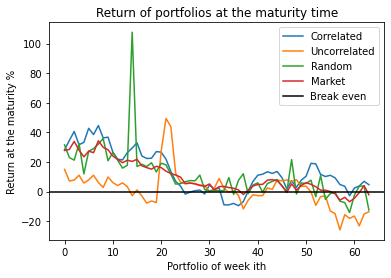

In [27]:
plt.plot((profit_correlated)*100, label = "Correlated")
plt.plot((profit_uncorrelated)*100, label = "Uncorrelated")
plt.plot((profit_random)*100, label = "Random")
plt.plot((profit_market)*100, label = "Market")
plt.title("Return of portfolios at the maturity time")
plt.axhline(0, c='k', label="Break even")
plt.xlabel("Portfolio of week ith")
plt.ylabel("Return at the maturity %")
plt.legend()
plt.show()

In [10]:
print(f"Expected return of correlated portfolio strategy: {np.mean(profit_correlated)*100}%")
print(f"Expected return of uncorrelated portfolio strategy: {np.mean(profit_uncorrelated)*100}%")
print(f"Expected return of random portfolio strategy: {np.mean(profit_random)*100}%")
print(f"Expected return of market portfolio strategy: {np.mean(profit_market)*100}%")

Expected return of correlated portfolio strategy: 13.563302594742913%
Expected return of uncorrelated portfolio strategy: 1.5738935576001862%
Expected return of random portfolio strategy: 10.86058228074945%
Expected return of market portfolio strategy: 9.840742373824524%


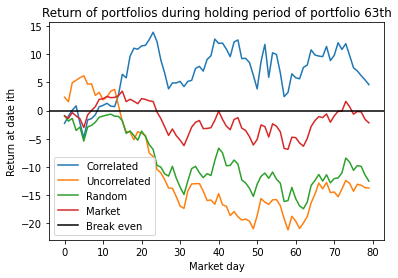

In [20]:
# Let see an indidual case
h = 63 # Chose portfolio from 0 to 63
plt.plot(performance_correlated[h]*100, label = "Correlated")
plt.plot(performance_uncorrelated[h]*100, label = "Uncorrelated")
plt.plot(performance_random[h]*100, label = "Random")
plt.plot(performance_market[h]*100, label = "Market")
plt.axhline(0, c='k', label="Break even")
plt.legend()
plt.title(f"Return of portfolios during holding period of portfolio {h}th")
plt.ylabel("Return at date ith")
plt.xlabel("Market day")
plt.show()

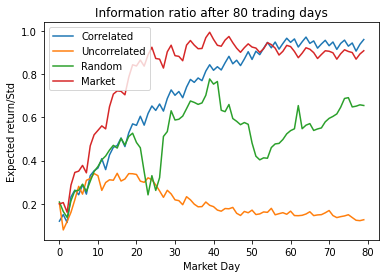

In [30]:
plt.plot(performance(performance_correlated), label = "Correlated")
plt.plot(performance(performance_uncorrelated), label = "Uncorrelated")
plt.plot(performance(performance_random), label = "Random")
plt.plot(performance(performance_market), label = "Market")
plt.legend()
plt.title(f"Information ratio after {maturity_time} trading days")
plt.xlabel("Market Day")
plt.ylabel("Expected return/Std")
plt.axis("tight")
plt.show()

In [21]:
# This week prediction (for fun)
# Not financial advice
today_correlated, today_uncorrelated = create_network(406, 526 )
today_portfolio_correlated = xy(today_correlated,  number_of_stock)
today_portfolio_uncorrelated = xy(today_uncorrelated, number_of_stock)
print(f"This week correlated stock strategy:{today_portfolio_correlated}")
print(f"This week uncorrelated stock strategy:{today_portfolio_uncorrelated}")

This week correlated stock strategy:['SIVB' 'DFS' 'WTFC' 'AMP' 'BHF' 'SF' 'ITT' 'EWBC' 'SNV' 'CR']
This week uncorrelated stock strategy:['CVX' 'XOM' 'QDEL' 'FL' 'MKC' 'HRL' 'K' 'PFE' 'LMT' 'NEM']
